## PyG package test
https://www.pyg.org/

In [ ]:
# pytorch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install -q torch-geometric

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from google.colab import drive
drive.mount('/content/drive')
device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tesla P100-PCIE-16GB


In [ ]:
filename='/content/drive/MyDrive/gnn/data/data_118_quad/118dc_quad_ISF.txt'
S=pd.read_table(filename,sep=',',header=None).to_numpy() #ISF matrix
filename='/content/drive/MyDrive/gnn/data/data_118_quad/118ac_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() #flow limit
n_line=np.size(S,0)
S=torch.from_numpy(S).to(device) #ISF
f_max=torch.from_numpy(f_max).squeeze().to(device) #flow limit
x=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/ac118_plimit_x.npy').transpose(2,0,1)
y=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/ac118_plimit_y.npy').transpose()
w=np.load('/content/drive/MyDrive/gnn/data/data_118_quad/ac118_p10_w.npy')
num_bus=y.shape[-1]
num_feat=x.shape[-1]
print(np.max(x),np.min(x),np.max(y),np.min(y))
print('Data size:',x.shape)
print('Label size:',y.shape)

# construct edge index from w
edge_index=[[],[]]
ans=0
for node in w:
  source=[]
  target=-1
  for idx,ele in enumerate(node):
    if ele>0: target=idx
    elif ele<0: source.append(idx)
  for ele in source:
    edge_index[0].append(target)
    edge_index[1].append(ele)
print('Num of edges:',len(edge_index[0])//2)
edge_index=torch.tensor(edge_index,dtype=torch.long)
from torch_geometric.data import Data
data=[]
for idx,ele in enumerate(x):
  data.append(Data(
      x=torch.tensor(ele,dtype=torch.float),
      edge_index=edge_index,
      y=torch.tensor([[temp] for temp in y[idx]],dtype=torch.float)
  ))
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
train,test=train_test_split(data)
trainset=DataLoader(train,batch_size=128,shuffle=True)
testset=DataLoader(test,batch_size=128,shuffle=True)

1654.8 -332.4 812.65 11.547
Data size: (8000, 118, 6)
Label size: (8000, 118)
Num of edges: 179


In [ ]:
from torch_geometric.nn import GCNConv
class myGCN(nn.Module):
  def __init__(self,sizes):
    super().__init__()
    self.conv1=GCNConv(num_feat,sizes[0])
    self.conv2=GCNConv(sizes[0],sizes[1])
    self.conv3=GCNConv(sizes[1],sizes[2])
    self.conv4=GCNConv(sizes[2],sizes[3])
    self.conv5=GCNConv(sizes[3],sizes[4])
    self.conv6=GCNConv(sizes[-1],1)
    self.lin=nn.Linear(num_bus,num_bus)
  def forward(self,batch):
    x=self.conv1(batch.x,batch.edge_index)
    x=self.conv2(x,batch.edge_index)
    x=F.relu(x)
    x=F.dropout(x)
    x=self.conv3(x,batch.edge_index)
    x=self.conv4(x,batch.edge_index)
    x=F.relu(x)
    x=F.dropout(x)
    x=self.conv5(x,batch.edge_index)
    x=self.conv6(x,batch.edge_index)
    x=x.reshape((-1,num_bus))
    x=self.lin(x)
    x=x.reshape((-1,))
    return x
net=myGCN([10,15,15,10,10]).to(device)
optimizer=torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)
loss_optm=[]
loss_val=[]
print(net)
print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

myGCN(
  (conv1): GCNConv(6, 10)
  (conv2): GCNConv(10, 15)
  (conv3): GCNConv(15, 15)
  (conv4): GCNConv(15, 10)
  (conv5): GCNConv(10, 10)
  (conv6): GCNConv(10, 1)
  (lin): Linear(in_features=118, out_features=118, bias=True)
)
number of params: 14798


In [ ]:
# loss func
class binary_thresh(nn.Module):
  def __init__(self): super().__init__()
  def forward(self,x,thresh):
    right_thresh=torch.tensor(thresh).double()
    left_thresh=torch.tensor(0).double()
    x=x.double()
    x=torch.where(x<left_thresh,0.,x)
    x=torch.where(x>right_thresh,right_thresh,x)
    return x
binary_cell=binary_thresh()
def f_feas_reg(x,pred,thresh,S,f_max):
  center=(pred.squeeze()-x[:,4])/(x[:,5]+1e-10)/2
  bus_inj=binary_cell(center,x[:,0]-x[:,1])+x[:,1]
  ans=[]
  for idx in range(0,bus_inj.shape[0],118):
    f=torch.matmul(S,bus_inj[idx:idx+num_bus])
    f=torch.abs(f)
    f=torch.where(f>f_max,f-f_max,0.)
    ans.append(f)
  ans=torch.cat(ans)
  return torch.sum(ans)
loss_func=nn.MSELoss()
def my_loss_func(pred,label,x,S,f_max):
  lmda1=torch.tensor(1).to(device) #L_2
  lmda2=torch.tensor(0.01).to(device) #L_inf
  lmda3=torch.tensor(0.1).to(device) #feasibility
  thresh=torch.tensor(0.97).to(device)
  mse=loss_func(pred,label)
  linf=(pred-label).norm(p=float('inf'))
  f_penalty=f_feas_reg(x,pred,thresh,S,f_max)
  return lmda1*mse+lmda2*linf+lmda3*f_penalty

In [ ]:
## Training
t0=time.time()
max_epochs=20
eval_epoch=5

# earlystopping
tolerance=10
min_delta=1e-3
previous=0
for epoch in range(max_epochs):
  # training
  train_loss=0.0
  for batch in trainset:
    optimizer.zero_grad() # clear the past gradient
    batch=batch.to(device)
    logits=net(batch)
    # loss=my_loss_func(logits,batch.y.squeeze(),batch.x,S,f_max)
    loss=loss_func(logits,batch.y.squeeze())
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(trainset.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(trainset.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for batch in testset:
      batch=batch.to(device)
      logits=net(batch)
      # loss=my_loss_func(logits,batch.y.squeeze(),batch.x,S,f_max)
      loss=loss_func(logits,batch.y.squeeze())
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(testset.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0: break
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    loss_val.append([epoch,eval_loss/len(testset.dataset)])
    net.train()
t1=time.time()
print("Training time: %.4fs"%(t1-t0))
# path='/content/drive/MyDrive/gnn/dnn_pytorch/sample_gnn_ac118.pickle'
# torch.save(net.state_dict(),path)

Epoch 0 | Training loss: 158.3178
Epoch 1 | Training loss: 22.6427
Epoch 2 | Training loss: 14.3403
Epoch 3 | Training loss: 12.4878
Epoch 4 | Training loss: 12.4435
Epoch 4 | Eval loss: 10.9432
Epoch 5 | Training loss: 10.8544
Epoch 6 | Training loss: 10.4020
Epoch 7 | Training loss: 10.4054
Epoch 8 | Training loss: 10.1072
Epoch 9 | Training loss: 9.9697
Epoch 9 | Eval loss: 9.0622
Epoch 10 | Training loss: 10.6400
Epoch 11 | Training loss: 9.3960
Epoch 12 | Training loss: 9.4412
Epoch 13 | Training loss: 9.5128
Epoch 14 | Training loss: 9.0715
Epoch 14 | Eval loss: 8.8581
Epoch 15 | Training loss: 8.9926
Epoch 16 | Training loss: 8.9332
Epoch 17 | Training loss: 8.8248
Epoch 18 | Training loss: 9.0570
Epoch 19 | Training loss: 9.7014
Epoch 19 | Eval loss: 11.0867
Training time: 13.7345s


4


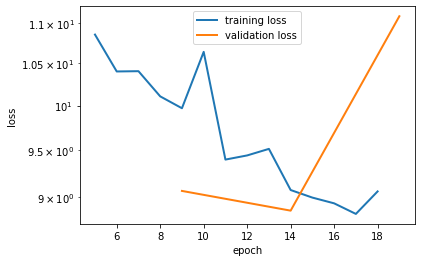

In [ ]:
import matplotlib.pyplot as plt
val_len=len(loss_val)
print(val_len)
val_plt=np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i]=loss_val[i][0]
  val_plt[1,i]=loss_val[i][1]
plt.figure()
plot_idx = np.arange(np.size(loss_optm))
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

(2000,) (2000,)
L2 mean: 0.0710102900993079 L_inf mean: 0.07832883938169106


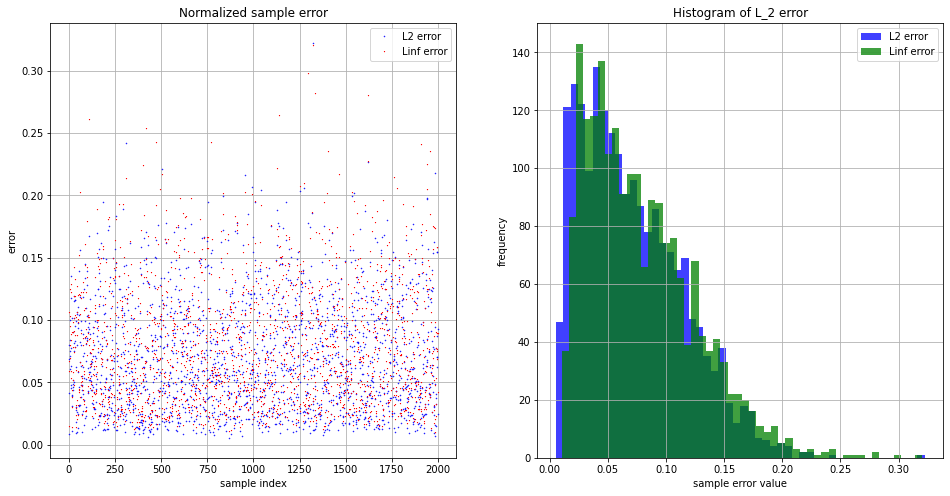

In [ ]:
net.eval()
y_pred=[]
y_label=[]
for batch in testset:
  batch=batch.to(device)
  logits=net(batch)
  y_pred.extend(logits.squeeze().cpu().detach().numpy())
  y_label.extend(batch.y.squeeze().cpu().detach().numpy())
y_pred=np.array(y_pred)
y_label=np.array(y_label)

n_test=len(test)
err_L2=np.zeros(n_test)
err_Linf=np.zeros(n_test)
for idx in range(0,len(y_label),num_bus):
  err_L2[idx//num_bus]=np.linalg.norm(y_label[idx:idx+num_bus]-y_pred[idx:idx+num_bus])/np.linalg.norm(y_label[idx:idx+num_bus])
  err_Linf[idx//num_bus]=np.max(np.abs(y_label[idx:idx+num_bus]-y_pred[idx:idx+num_bus]))/np.max(np.abs(y_label[idx:idx+num_bus]))
print(err_L2.shape,err_Linf.shape)
err_L2_mean=np.mean(err_L2)
err_Linf_mean=np.mean(err_Linf)
print('L2 mean:',err_L2_mean,'L_inf mean:',err_Linf_mean)

fig2=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(err_L2,'bo',markersize=0.5,label='L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label='Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(1,2,2)
plt.hist(err_L2,bins=50,facecolor='b',alpha=0.75,label='L2 error')
plt.hist(err_Linf,bins=50,facecolor='g',alpha=0.75,label='Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
plt.grid(True)
plt.show()

2000 L2 mean: 0.0710102900993079 2000 L_inf mean: 0.07832883938169106


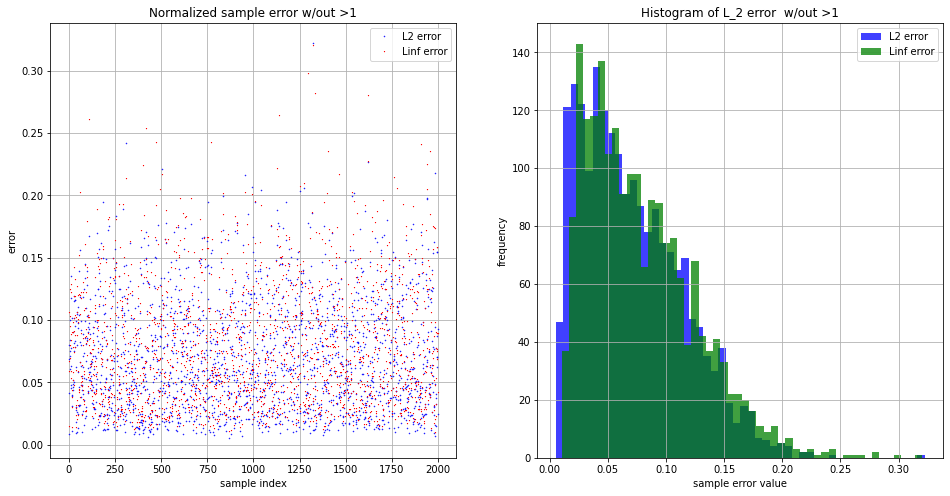

In [ ]:
err_l2_new = [i for i in err_L2 if i < 1]
err_linf_new = [i for i in err_Linf if i < 1]
print(len(err_l2_new),'L2 mean:', np.mean(err_l2_new),len(err_linf_new),'L_inf mean:', np.mean(err_linf_new) )

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_l2_new,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_linf_new,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error w/out >1')
plt.grid(True)
# error histogram
plt.subplot(1, 2, 2)
plt.hist(err_l2_new, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error  w/out >1')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
## LMP mismatch
# print(y_test[:,1], y_pred1[:,1])
index = 1
y_test_copy = y_pred1[:,index].copy()
print(y_test_copy.shape)
for i in range(118):
  if y_test_copy[i] < 0.1:
    y_test_copy[i] = y_test[i,index] + 50

print(np.linalg.norm(y_test_copy - y_test[:,index]) / np.linalg.norm(y_test[:,index]))

NameError: ignored

In [ ]:
# y_test_copy
# y_pred1[:,index]

# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [ ]:
gen_limit0 = x[:,4,:].copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

In [ ]:
# # get the generator index
# # generator cost data
# gen_cost0
# # generator limit data
# gen_limit0
# # LMP data
# lmp_data
# # generation data
# gen_data

load_data = x.copy()
load_data = load_data[:,:]
print(load_data.shape)
n_sample = np.size(load_data,2)

# predict the corredponding LMP
x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
batch_size=2000
y_pred1=[]
with torch.no_grad():
  for idx in range(0,x_val_feed.shape[0],batch_size):
    current_batch=x_val_feed[idx:idx+batch_size]
    current_batch=current_batch.to(device)
    current_y=net(current_batch)
    current_y=current_y.cpu().detach()
    current_y=torch.squeeze(current_y,1).numpy().tolist()
    y_pred1+=current_y
y_pred1=np.array(y_pred1).transpose()

print('Dataset size:',x_val_feed.shape)
print('Number of validation points:: ',n_sample)

# net1 = net.cpu()
# y_pred = net1(x_val_feed)

# y_pred1 = y_pred.cpu().detach()
print('output size',y_pred1.shape)
# y_pred1 = torch.squ[]eeze(y_pred1,1).numpy().transpose()
print('reshaped size',y_pred1.shape)

# load_data = x.copy()
# print(load_data.shape)
# n_sample = np.size(load_data,2)

# x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
# x_val_feed = x_val_feed.to(device)

# print('Dataset size:',x_val_feed.shape)
# print('Number of validation points:: ',n_sample)
# y_pred = net(x_val_feed) # predict the corredponding LMP

# y_pred1 = y_pred.cpu().detach()
# print('output size',y_pred1.shape)
# y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
# print('reshaped size',y_pred1.shape)

* Save results

In [ ]:
import pickle

In [ ]:
# dataset = {'lmp_pred': y_pred1, 'lmp_true': lmp_data}
# print('Pred:',y_pred1.shape,'True:',lmp_data.shape)

# file_name = 'dc118_lmp_prediction_p10'
# file_path = 'drive/My Drive/gnn/data/results/'
# file_dir = file_path + file_name + '.pickle'
# outfile = open(file_dir, 'wb')
# pickle.dump(dataset, outfile)
# outfile.close()

In [ ]:
gen_cost0 = x[:,4,:].copy()
lmp_data = y.copy()

quadratic_a = x[:,5,:].copy()

profit_pred = y_pred1 - gen_cost0
print(np.min(np.abs(profit_pred)))

profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))

profit_pred=(y_pred1-gen_cost0)/(quadratic_a+1e-10)/2
profit_true=(lmp_data-gen_cost0)/(quadratic_a+1e-10)/2
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

In [ ]:
p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)

In [ ]:
print(np.min(p_pred_sort),np.min(p_true_sort))

In [ ]:
fig2 = plt.figure(figsize=(8, 8))
plt.hist(p_pred_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. profit')
plt.hist(p_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true profit')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('profit histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
# gen_pred_binary = np.zeros((len(gen_idx),n_sample))
# gen_true_binary = np.zeros((len(gen_idx),n_sample))
# print(gen_pred_binary.shape)

# binary_thres = 2.5
# binary_thres_true = 1e-5

# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres:
#       gen_pred_binary[j,i] = 1
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary[j,i] = 0
#     else:
#       # gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i] + binary_thres) / (2*binary_thres)
#       gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i]) / (binary_thres)
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres_true:
#       gen_true_binary[j,i] = 1
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary[j,i] = 0
#     else:
#       gen_true_binary[j,i] = 0.5

# gen_binary_err = np.abs(gen_true_binary - gen_pred_binary)
# print('max binary error:',np.max(gen_binary_err))
# # count the wrong entries
# gen_binary_err_ct = np.sum(gen_binary_err)
# gen_binary_err_ratio = gen_binary_err_ct / (len(gen_idx)*n_sample)
# print('Binary accuracy:',1-gen_binary_err_ratio)

In [ ]:
print(gen_limit0.shape)
print(np.transpose(x_test).shape,np.transpose(load_data).shape)

 # Test flow feasibility

In [ ]:
x[:,2,:].shape
profit_pred.shape
# n_sample

In [ ]:
# x = [load, gen_cost, gen_lim]

# binary_thres = 0.97
binary_thres_true = 1e-5
# binary_thres = gen_limit0
binary_thres = x[:,0,:].copy() # upper
binary_thres_lo = x[:,1,:].copy() # lower

gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))
# print(gen_pred_binary.shape,profit_pred.shape,gen_pred_binary_full.shape)

# x[:,2,:] # p_max

# ## generator injection
# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

## nodal injection
# gen_limit0 = x[:,2,:].copy()
for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]


# injection by generators
# gen_inj = np.multiply(gen_pred_binary_full,gen_limit0)
# gen_inj_true = np.multiply(gen_true_binary_full,gen_limit0)
gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x[:,1,:].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0

In [ ]:
# load0 = x[:,0,:].copy()
print(np.sum(p_inj_true),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

* Calculate flow

In [ ]:
n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
f_max_numpy = f_max.cpu().detach().numpy()
f_binary = (np.abs(flow_est)-f_max_numpy > 0)
f_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)

In [ ]:
f_tot_sample = n_line * n_sample
print(np.sum(f_binary),np.sum(f_binary0))
print(np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)

In [ ]:
print(n_line,n_sample,flow_est.shape)

In [ ]:
# soft threshold
f_err_est = np.abs(flow_est)-f_max_numpy
f_err_true = np.abs(flow_est0)-f_max_numpy

f_err_est = np.maximum(np.abs(flow_est)-f_max_numpy,0) # identify violations
f_err_true = np.maximum(np.abs(flow_est0)-f_max_numpy,0)

print(np.max(f_err_est),np.max(f_err_true))
print(np.max(f_err_est/f_max_numpy),np.max(f_err_true/f_max_numpy))

# a= np.asarray([[1,2,1],[2,2,1]])
# b = np.asarray([1,1,1])
# c = (a-b>0)
# print(c)
# print(np.sum(c))

In [ ]:
# f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.01*np.max(f_max_numpy))
# f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.01*np.max(f_max_numpy))
f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.1*(f_max_numpy))
f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(f_binary_soft),np.sum(f_binary0_soft))
print(np.sum(f_binary_soft)/f_tot_sample,np.sum(f_binary0_soft)/f_tot_sample)

In [ ]:
f_pred_sort = np.reshape(f_err_est/f_max_numpy,n_line*n_sample)
f_true_sort = np.reshape(f_err_true/f_max_numpy,n_line*n_sample)

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(f_pred_sort, bins = 10, facecolor='b', alpha=0.75,label = 'pred. f')
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
plt.subplot(1,2,2)
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [ ]:
f_line = np.sum(f_binary,0)
f_samp = np.sum(f_binary,1)
print('max sample pred:',np.max(f_line))
print('max line pred:',np.max(f_samp))

f_line0  = np.sum(f_binary0,0)
f_samp0 = np.sum(f_binary0,1)
print('max sample true:',np.max(f_line0))
print('max line true:',np.max(f_samp0))